For Part III of this assignment, I will create my own signal and feed this into the above model. I will use an entropy, i.e information theory, based signal.

At each timestep I will see if the returns are positive (+1) or negative (-1). This then will create a binary byte array of ones and negative ones. I will then measure the entropy of a rolling window of length "entropy_time_lag" for each stock. 


Likewise, I optmise for thirty-four (34) parameters, with the following initial parameters:
- The theta value (0.0)
- The sigma value (1.0)
- The kappa value (0.0)
- The g value (0.0)
- The weights vector with thirty free parameters [0.0]x30

I also use the Adam Gradient Descent optmisation algorithm as this has a variable lerning rate which is applicable and useful in such a high dimensional space. 

I also normalise the data by first switching the raw data into log space, and then normalising by the initial mean market cap at time 0. This ensure that the model can converge efficiently and accurately. It improves model performace and is a tractable space transformation.

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [0]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')
####Take logs of the market caps
df_cap = np.log(df_cap)

In [0]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap = ((df_cap/np.mean(df_cap.iloc[0])))  #renormalise the market caps to all start with a number close to 1
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.029948,0.975192,0.968230,0.963754,1.017642,1.022018,0.984592,0.960248,1.023463,0.999109,...,0.949737,1.020527,1.026716,0.952164,0.963947,0.987959,0.968728,1.001511,1.032497,1.050714
2010-01-05,1.030017,0.975105,0.969507,0.964225,1.017465,1.022298,0.984493,0.961976,1.023667,0.999803,...,0.949894,1.019957,1.026729,0.951214,0.963884,0.987362,0.968272,1.001582,1.032101,1.050869
2010-01-06,1.029381,0.975741,0.970691,0.964345,1.017206,1.022303,0.984282,0.962672,1.023463,0.999378,...,0.949652,1.019830,1.026540,0.950647,0.964272,0.987154,0.967736,0.999857,1.032012,1.051210
2010-01-07,1.029308,0.976206,0.972264,0.964505,1.017384,1.022153,0.984295,0.962697,1.025463,1.000146,...,0.950617,1.019680,1.026325,0.951214,0.965765,0.987323,0.968103,0.999621,1.032034,1.051085
2010-01-08,1.029571,0.976178,0.971880,0.964947,1.017594,1.022223,0.984357,0.962837,1.026308,0.999389,...,0.950538,1.020000,1.026272,0.951157,0.965391,0.987402,0.968213,0.999646,1.031834,1.050926


In [0]:
####Part III my own signal - N-day binary entropy
#####Measure my signal
from scipy.stats import entropy
prices = np.array(df_cap).astype(float)
updown = np.zeros((2080, 30), 'float')  # matrix of stock values
entropy_updown = np.zeros((2080, 30), 'float') 

for row in range(1,df_cap.shape[0]):
    for column in range(df_cap.shape[1]):
        if (prices[row, column] > prices[row - 1, column]):
            updown[row, column] = +1
        else:
            updown[row, column] = -1

entropy_time_lag = 10
for row in range(entropy_time_lag,df_cap.shape[0]):
    for column in range(df_cap.shape[1]):
        unique, counts = np.unique(updown[row-entropy_time_lag:row, column], return_counts=True)
        entropy_updown[row, column] = entropy(counts/np.sum(counts))


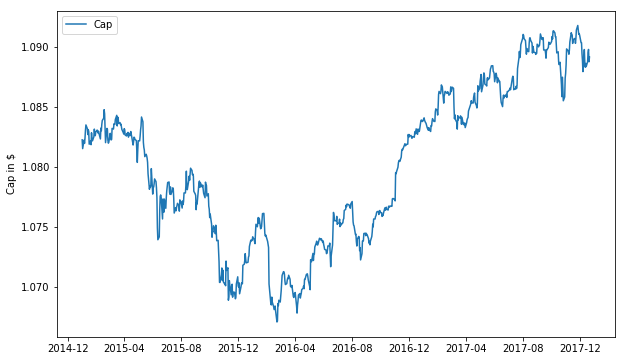

In [0]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

In [0]:
####Part 1
####Declaring Hyperparamters
learning_rate = 0.01
training_epochs = 50
training_steps = 38 
batch_length = 50
first_index = 100

####Declaring raw log data (i.e all timeseries start at 100)
times_data = np.arange(df_cap.shape[0]-1).astype(int)
stock_prices_data = np.array(df_cap).astype(float)
signals_data = np.array(entropy_updown).astype(float)

####Declaring constant placeholders
times = tf.placeholder(tf.int32, shape=[None])  #times = tf.constant(np.arange(int(stock_prices_data.shape[0])), dtype = tf.int32)
stock_prices = tf.placeholder(tf.float32, shape=[None, None])  #stock_prices = tf.constant(np.array(df_cap), dtype = tf.float32)
signals = tf.placeholder(tf.float32, shape=[None, None])  #signals = tf.constant(np.array(entropy_updown), dtype = tf.float32)

####Declaring variable placeholders
theta = tf.Variable(initial_value=0.0, dtype=tf.float32)
sigma = tf.Variable(initial_value=1.0, dtype=tf.float32)
kappa = tf.Variable(initial_value=0.0, dtype=tf.float32)
little_g = tf.Variable(initial_value=0.0, dtype=tf.float32)   
weights_vector = tf.Variable(initial_value=0.0*tf.ones(df_cap.shape[1], dtype=tf.float32), dtype=tf.float32)

####Declaring Lambda functions
def delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    delta_V_over_delta_y_t - compute the partial derivative of V with respect to y that is used in the minimum likelihood equation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    delta_V_over_delta_y_t_function - a lambda function which returns the partial derivative vector at a given time index
    """
    delta_V_over_delta_y_t_function = lambda index:  (((tf.pow(sigma, 2)/2.0) - theta -  (tf.tensordot( weights_vector,tf.squeeze(tf.gather(signals, [index])),1)))*tf.ones(30, dtype=tf.float32)  ) + (kappa*tf.exp(tf.squeeze(tf.gather(stock_prices, [index])))) + (little_g*tf.exp(2.0*tf.squeeze(tf.gather(stock_prices, [index]))))
    return delta_V_over_delta_y_t_function 

def neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices):
    """
    neg_log_likelihood_t - compute the negative log likelihood scalar that is minimised in the optimisation.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    Return:
    neg_log_likelihood_t_function - a lambda function which returns the log_likelihood scalar function at a given time index
    """ 
    delta_V_over_delta_y_time = delta_V_over_delta_y_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    ####ignore 2pi term as it is a constant and does blow up 
    neg_log_likelihood_t_function = lambda index: tf.log(tf.abs(sigma)) + ( (1.0/(2.0*sigma*sigma)) * ((tf.norm(((((tf.squeeze(tf.gather(stock_prices, [index+1])) - tf.squeeze(tf.gather(stock_prices, [index]))))   ) ) + delta_V_over_delta_y_time(index)))**2))
    return neg_log_likelihood_t_function

def log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times):
    """
    log_likelihood - compute the summed negative log likelihood scalar that is the sum over times of neg_log_likelihood_t.

    Arguments:
    theta - a tensorflow object that represents the theta value
    sigma - a tensorflow object that represents the sigma value
    kappa - a tensorflow object that represents the kappa value
    little_g - a tensorflow object that represents the little_g value
    stock_prices - a tensorflow object that represents the raw stock prices matrix (2080 x 30 array)
    weights_vector - a tensorflow object that represents the factor loading vector (length 30)
    signals - a tensorflow object that represents the raw signals matrix (2080 x 30 array)
    times - a tensorflow object that represents the vector of indices for which we sum across
    Return:
    LL_theta_t_map_result_remove_nans - a scalar of the negative log likelihood function across indices in times
    """ 
    LL_theta_t = neg_log_likelihood_t(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices)
    LL_theta_t_map_result = tf.map_fn(LL_theta_t, times, dtype=tf.float32)
    LL_theta_t_map_result_remove_nans = tf.where(tf.is_nan(LL_theta_t_map_result), tf.zeros_like(LL_theta_t_map_result), LL_theta_t_map_result)
    return LL_theta_t_map_result_remove_nans
    
####Creating the log sum and creating the error term
LL_theta_t_map_result_remove_nans = log_likelihood(theta, sigma, kappa, little_g, weights_vector, signals, stock_prices, times)
error = tf.reduce_sum(LL_theta_t_map_result_remove_nans, 0)

####Gradient of the log likelihood
grad = tf.gradients(error, [theta, sigma, kappa, little_g])
grad_weights = tf.gradients(error, [weights_vector])

####The Adam Gradient Descent Optimizer does the heavy lifting
train_op = tf.train.AdamOptimizer(learning_rate).minimize(error)

####Normal TensorFlow - initialize values, create a session and run the model
model = tf.global_variables_initializer()

####Summaries
tf.summary.scalar("loss",error)
merged_summary_op = tf.summary.merge_all()

with tf.Session() as sess:
    sess.run(model)
        
    print("starting at", "theta:", sess.run(theta))
    print("starting at", "sigma:", sess.run(sigma))
    print("starting at", "kappa:", sess.run(kappa))
    print("starting at", "g:", sess.run(little_g))
    print("starting at", "weights:", sess.run(weights_vector)) 

    obs_theta, obs_sigma, obs_kappa, obs_little_g, obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
    
    errors = np.array([1])
    gradients = np.empty(shape=[4])
    gradients_weights = np.empty(shape=[30])

    for epoch in range(training_epochs):
        for step in range(training_steps):
            stock_prices_data = np.array(df_cap).astype(float)
            signals_data = np.array(entropy_updown).astype(float)
            starting_index = first_index + step*batch_length
            times_data = np.arange(df_cap.shape[0]-1).astype(int)[starting_index:starting_index+batch_length]
            print(epoch, starting_index, starting_index+batch_length)
            op, numerical_error, summary = sess.run([train_op, error, merged_summary_op], feed_dict={stock_prices: stock_prices_data, signals: signals_data, times: times_data})
            print("numerical_error:", numerical_error)
            
            new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector = sess.run(fetches=[theta, sigma, kappa, little_g, weights_vector])
            numerical_error = sess.run(fetches=error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients = sess.run(fetches=grad, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            new_gradients_weights = sess.run(fetches=grad_weights, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data})
            
            errors = np.append(errors, numerical_error)
            obs_theta = np.append(obs_theta, new_obs_theta)
            obs_sigma = np.append(obs_sigma, new_obs_sigma)
            obs_kappa = np.append(obs_kappa, new_obs_kappa)
            obs_little_g = np.append(obs_little_g, new_obs_little_g)
            obs_weights_vector = np.vstack([obs_weights_vector, new_obs_weights_vector])
            gradients = np.vstack([gradients,new_gradients])
            gradients_weights = np.vstack([gradients_weights,new_gradients_weights])
            print(new_obs_theta, new_obs_sigma, new_obs_kappa, new_obs_little_g, new_obs_weights_vector[0])
            
    print("ending at", "theta:", sess.run(theta))
    print("ending at", "sigma:", sess.run(sigma))
    print("ending at", "kappa:", sess.run(kappa))
    print("ending at", "g:", sess.run(little_g))
    print("ending at", "weights:", sess.run(weights_vector))      
    print("ending at", "error:", sess.run(error, feed_dict={stock_prices: stock_prices_data, signals: signals_data, times:times_data}))
    
    sess.close()



starting at theta: 0.0
starting at sigma: 1.0
starting at kappa: 0.0
starting at g: 0.0
starting at weights: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
0 100 150
numerical_error: 187.51764
0.009999999 0.99 -0.01 -0.01 0.009999999
0 150 200
numerical_error: 26.283688
0.018913306 0.98031175 -0.018913709 -0.018914111 0.01870355
0 200 250
numerical_error: 5.5049534
0.024597045 0.97419745 -0.02458984 -0.024582617 0.024263818
0 250 300
numerical_error: 60.41705
0.025922196 0.974669 -0.025889345 -0.025856383 0.025489701
0 300 350
numerical_error: 75.21966
0.024357123 0.9784057 -0.024292767 -0.024228318 0.023811895
0 350 400
numerical_error: 53.37393
0.021188892 0.9836189 -0.021093195 -0.020997496 0.020610316
0 400 450
numerical_error: 19.538658
0.017399646 0.9891729 -0.017276637 -0.017153675 0.016838716
0 450 500
numerical_error: 0.78876245
0.013802324 0.9941259 -0.013653539 -0.013504835 0.0132546155
0 500 550
numerical_error: 4.415574
0.01112

numerical_error: -7.974384
0.013830237 0.84377193 -0.012455887 -0.011072226 0.012160776
2 450 500
numerical_error: -8.393483
0.013769205 0.84012085 -0.012376309 -0.010974013 0.0120762335
2 500 550
numerical_error: -8.628375
0.013789656 0.83636576 -0.012377853 -0.010956557 0.012068261
2 550 600
numerical_error: -8.754737
0.013896881 0.83250433 -0.012465839 -0.0110252 0.012140173
2 600 650
numerical_error: -9.069899
0.0139510315 0.8286506 -0.012500164 -0.011039589 0.012160033
2 650 700
numerical_error: -9.284519
0.013908607 0.82484 -0.012437022 -0.0109556 0.012086219
2 700 750
numerical_error: -9.506347
0.013770357 0.8210714 -0.012277378 -0.010774426 0.011917111
2 750 800
numerical_error: -9.763753
0.013593303 0.81729716 -0.012078611 -0.01055381 0.011711691
2 800 850
numerical_error: -10.006732
0.013421445 0.8134812 -0.011884997 -0.010338297 0.011512794
2 850 900
numerical_error: -10.238522
0.013286175 0.8095983 -0.011728233 -0.010159888 0.0113555435
2 900 950
numerical_error: -10.199944

0.008462737 0.38010705 -0.0051279087 -0.0017580078 0.0040746224
4 750 800
numerical_error: -48.34949
0.008375296 0.3709513 -0.0050106877 -0.0016108209 0.0039407765
4 800 850
numerical_error: -49.57188
0.0082736565 0.3616261 -0.004879292 -0.0014494779 0.0037955954
4 850 900
numerical_error: -50.83766
0.008257455 0.3520938 -0.004834225 -0.0013753375 0.0037410632
4 900 950
numerical_error: -52.166405
0.008283294 0.34235913 -0.004831788 -0.001344403 0.0037372638
4 950 1000
numerical_error: -53.497326
0.007870409 0.33254886 -0.004386667 -0.0008668507 0.0033124848
4 1000 1050
numerical_error: -54.57747
0.008530032 0.32226273 -0.005025737 -0.0014850323 0.0039685224
4 1050 1100
numerical_error: -54.902817
0.0070673544 0.31239447 -0.0035193986 6.51069e-05 0.002464786
4 1100 1150
numerical_error: -51.403305
0.009821112 0.3015271 -0.006280306 -0.0027025302 0.005096438
4 1150 1200
numerical_error: -32.34834
0.004896537 0.29430294 -0.0012969915 0.002338955 0.00038338266
4 1200 1250
numerical_error:

numerical_error: -47.33868
0.009111319 0.38301456 -0.0048502833 -0.000555006 0.015627341
6 1050 1100
numerical_error: -46.38634
0.009080694 0.38163915 -0.0048200763 -0.000525248 0.015577154
6 1100 1150
numerical_error: -46.50163
0.009241985 0.38010257 -0.0049829623 -0.0006897336 0.015713409
6 1150 1200
numerical_error: -47.281742
0.009536442 0.378438 -0.0052797957 -0.0009889305 0.015968664
6 1200 1250
numerical_error: -48.51089
0.009823282 0.3767212 -0.005568721 -0.0012799236 0.01621642
6 1250 1300
numerical_error: -48.55195
0.010011344 0.37500936 -0.005757813 -0.001470032 0.01637016
6 1300 1350
numerical_error: -47.750256
0.010010377 0.37336504 -0.0057560313 -0.0014674352 0.01632976
6 1350 1400
numerical_error: -47.888603
0.009833126 0.37178385 -0.005576258 -0.0012851501 0.016115023
6 1400 1450
numerical_error: -48.95031
0.009566734 0.3702119 -0.0053067273 -0.001012504 0.015812984
6 1450 1500
numerical_error: -49.645245
0.009306092 0.3685949 -0.005042878 -0.00074546674 0.015519133
6 1

numerical_error: -89.55843
0.007923656 0.1616143 -0.0034875572 0.0009827758 0.011433036
8 1350 1400
numerical_error: -90.89726
0.0077391774 0.15706308 -0.0033021548 0.0011690619 0.011164458
8 1400 1450
numerical_error: -91.94744
0.007879994 0.152338 -0.0034443673 0.0010254567 0.011216163
8 1450 1500
numerical_error: -93.9174
0.00787984 0.14752719 -0.003444832 0.0010243581 0.01112948
8 1500 1550
numerical_error: -95.32467
0.0076439977 0.14264686 -0.003208712 0.0012607155 0.010809483
8 1550 1600
numerical_error: -96.1817
0.007915426 0.13755204 -0.0034838966 0.000981777 0.0109383175
8 1600 1650
numerical_error: -97.92206
0.0076411497 0.1324483 -0.0032094177 0.0012564196 0.010544905
8 1650 1700
numerical_error: -100.84269
0.007542656 0.12715186 -0.003112723 0.0013512777 0.01033863
8 1700 1750
numerical_error: -101.97558
0.007990607 0.12160853 -0.003567603 0.00088945625 0.010665815
8 1750 1800
numerical_error: -99.676056
0.0071055223 0.116272256 -0.0026753403 0.0017888116 0.00971221
8 1800 

numerical_error: -48.33423
0.0100189615 0.3782016 -0.003622694 0.0027941752 0.0069137164
10 1650 1700
numerical_error: -48.5777
0.009961085 0.37724134 -0.0035658535 0.002849956 0.00684101
10 1700 1750
numerical_error: -48.57715
0.009945955 0.37625402 -0.0035520513 0.0028624171 0.0068109115
10 1750 1800
numerical_error: -48.53134
0.009984241 0.37523618 -0.0035921505 0.002820503 0.0068329587
10 1800 1850
numerical_error: -48.88947
0.010050398 0.37419835 -0.0036604127 0.0027501385 0.0068846247
10 1850 1900
numerical_error: -49.098263
0.010125759 0.3731487 -0.0037379817 0.002670364 0.006947542
10 1900 1950
numerical_error: -49.255245
0.01018507 0.37209854 -0.0037993242 0.002606987 0.006996746
10 1950 2000
numerical_error: -49.39181
0.010238406 0.3710437 -0.0038546245 0.0025497146 0.007040838
11 100 150
numerical_error: -49.255184
0.010232669 0.37000865 -0.0038515811 0.0025500627 0.0070246626
11 150 200
numerical_error: -49.47435
0.01018721 0.3689847 -0.0038092567 0.002589254 0.0069686
11 2

numerical_error: -63.64994
0.00931187 0.27826083 -0.0031160382 0.0031005475 0.0052931425
12 1900 1950
numerical_error: -63.907776
0.0092904875 0.2767355 -0.003097886 0.003115427 0.00526473
12 1950 2000
numerical_error: -64.12983
0.009307079 0.27518857 -0.0031182468 0.003091253 0.0052744313
13 100 150
numerical_error: -64.35013
0.009268534 0.27365005 -0.003084283 0.00312061 0.0052273106
13 150 200
numerical_error: -64.68951
0.009223097 0.27210394 -0.0030435636 0.003156602 0.005166931
13 200 250
numerical_error: -64.955376
0.00920847 0.27053824 -0.0030333374 0.003162432 0.005134705
13 250 300
numerical_error: -65.323814
0.009190538 0.26896304 -0.0030198758 0.0031714363 0.0051007755
13 300 350
numerical_error: -65.625046
0.0091727255 0.26737705 -0.0030065598 0.003180275 0.00506867
13 350 400
numerical_error: -65.915245
0.009165468 0.26577693 -0.0030037488 0.0031786659 0.0050481036
13 400 450
numerical_error: -66.170616
0.009169284 0.2641627 -0.003011959 0.0031660993 0.005039385
13 450 500

numerical_error: -85.731415
0.007487783 0.09709185 -0.0019905209 0.0035269894 0.0011023541
15 250 300
numerical_error: -80.11269
0.009031025 0.094449855 -0.0035450493 0.0019614552 0.0025198287
15 300 350
numerical_error: -53.717667
0.006605247 0.09331639 -0.0011605655 0.0043043 -0.00010597333
15 350 400
numerical_error: 57.339985
0.01059607 0.09474343 -0.0051465565 0.00032390794 0.0035447355
15 400 450
numerical_error: 395.9364
0.004619028 0.105791695 0.000746279 0.006132525 -0.0023576294
15 450 500
numerical_error: 627.20966
0.008710639 0.123982474 -0.0033629043 0.0020067836 0.001932225
15 500 550
numerical_error: -85.387535
0.011169469 0.14048146 -0.0058415243 -0.00049090874 0.0046566525
15 550 600
numerical_error: 240.4967
0.008871041 0.1591976 -0.0035633056 0.001767097 0.0029807168
15 600 650
numerical_error: -71.7959
0.005844311 0.17619976 -0.0005572799 0.0047523207 0.00046327314
15 650 700
numerical_error: 22.262804
0.0051419167 0.19180797 0.0001250697 0.005414653 0.00023436571
1

numerical_error: -61.52406
0.008101917 0.2901452 -0.00302246 0.0020786463 0.0062439046
17 500 550
numerical_error: -61.79668
0.008068891 0.28881732 -0.0029910011 0.0021085383 0.006200807
17 550 600
numerical_error: -61.960617
0.008075242 0.287467 -0.0029989425 0.0020990102 0.006192836
17 600 650
numerical_error: -62.291775
0.008090595 0.28610456 -0.00301594 0.002080373 0.0061959075
17 650 700
numerical_error: -62.503082
0.008088569 0.28473958 -0.0030156476 0.0020789346 0.0061815428
17 700 750
numerical_error: -62.732967
0.008073069 0.28337073 -0.0030019379 0.0020908536 0.006154036
17 750 800
numerical_error: -63.000076
0.008065069 0.2819905 -0.0029957572 0.002095216 0.0061352546
17 800 850
numerical_error: -63.243538
0.008048622 0.28060445 -0.0029811158 0.0021080496 0.00610885
17 850 900
numerical_error: -63.409576
0.00804438 0.27920592 -0.0029787607 0.0021085173 0.0060967444
17 900 950
numerical_error: -63.613297
0.008074903 0.2777873 -0.0030113363 0.0020738973 0.006121548
17 950 1000

numerical_error: -95.75697
0.0072590485 0.14291787 -0.002452903 0.0023726968 0.0040838574
19 750 800
numerical_error: -97.05099
0.0073948996 0.14020082 -0.0025968323 0.0022206968 0.0042006737
19 800 850
numerical_error: -97.280594
0.007263883 0.13749328 -0.00247319 0.0023369123 0.0040434278
19 850 900
numerical_error: -98.90403
0.0071602454 0.13473353 -0.002377373 0.0024248601 0.003919256
19 900 950
numerical_error: -99.315
0.0072882376 0.13189358 -0.0025145942 0.0022784153 0.0040376144
19 950 1000
numerical_error: -101.03404
0.0072862348 0.12902129 -0.0025212297 0.002263105 0.0040248837
19 1000 1050
numerical_error: -102.16059
0.007193934 0.12610716 -0.0024371138 0.0023389685 0.003920481
19 1050 1100
numerical_error: -103.37732
0.0071657086 0.123123206 -0.0024179833 0.0023489376 0.0038818286
19 1100 1150
numerical_error: -104.57365
0.007203171 0.12006661 -0.002465597 0.0022911015 0.0039051443
19 1150 1200
numerical_error: -105.81893
0.007230276 0.11694584 -0.0025031774 0.0022429526 0.

0.008283306 0.48791644 -0.0059691584 -0.0036062277 0.0009670515
21 950 1000
numerical_error: -34.333355
0.008496289 0.48788068 -0.0061816843 -0.0038182472 0.001187523
21 1000 1050
numerical_error: -35.120705
0.008719839 0.48782718 -0.006404649 -0.0040405756 0.0014186648
21 1050 1100
numerical_error: -35.657597
0.008938399 0.48776048 -0.0066225505 -0.00425777 0.0016446572
21 1100 1150
numerical_error: -35.863434
0.009134538 0.48768556 -0.006817985 -0.0044524567 0.0018476095
21 1150 1200
numerical_error: -35.759743
0.0092997365 0.48760557 -0.00698243 -0.00461611 0.0020189043
21 1200 1250
numerical_error: -35.627865
0.00943459 0.48752165 -0.007116471 -0.0047493083 0.0021590968
21 1250 1300
numerical_error: -35.267372
0.009526859 0.4874376 -0.007207846 -0.0048397686 0.002257226
21 1300 1350
numerical_error: -34.782825
0.009570235 0.48735598 -0.0072502396 -0.004881169 0.002302688
21 1350 1400
numerical_error: -34.685356
0.009567679 0.487277 -0.007246618 -0.0048764823 0.0023004916
21 1400 14

numerical_error: -36.964523
0.008970884 0.4768133 -0.0065558786 -0.004093076 0.0016049095
23 1200 1250
numerical_error: -36.86644
0.00897358 0.47664943 -0.00655728 -0.004093196 0.001606139
23 1250 1300
numerical_error: -37.001694
0.0089770695 0.47648522 -0.006559481 -0.0040941187 0.0016081877
23 1300 1350
numerical_error: -37.023888
0.008976409 0.47632167 -0.0065575317 -0.0040908917 0.001605952
23 1350 1400
numerical_error: -37.042835
0.0089727305 0.47615853 -0.0065525654 -0.004084648 0.0016008503
23 1400 1450
numerical_error: -37.061512
0.008969866 0.475995 -0.0065484187 -0.004079229 0.0015965808
23 1450 1500
numerical_error: -37.04414
0.008965609 0.47583157 -0.006542881 -0.0040724203 0.0015910567
23 1500 1550
numerical_error: -37.097645
0.008961096 0.47566798 -0.006537088 -0.004065356 0.0015853717
23 1550 1600
numerical_error: -37.124504
0.008958251 0.47550383 -0.00653296 -0.0040599545 0.0015815637
23 1600 1650
numerical_error: -37.087402
0.008957836 0.475339 -0.006531267 -0.00405699

0.008940277 0.46294358 -0.00641512 -0.003843407 0.0014731934
25 1450 1500
numerical_error: -38.433872
0.008937592 0.46276435 -0.006411086 -0.0038380323 0.0014691356
25 1500 1550
numerical_error: -38.490356
0.008933725 0.46258512 -0.0064058686 -0.0038314743 0.0014639798
25 1550 1600
numerical_error: -38.520412
0.0089308815 0.46240544 -0.0064016716 -0.0038259327 0.0014601315
25 1600 1650
numerical_error: -38.489265
0.008929768 0.46222523 -0.006399207 -0.0038221255 0.0014572315
25 1650 1700
numerical_error: -38.53326
0.008926841 0.46204516 -0.0063949227 -0.0038164915 0.001452609
25 1700 1750
numerical_error: -38.560978
0.008920246 0.4618656 -0.0063869585 -0.0038071675 0.0014446584
25 1750 1800
numerical_error: -38.536243
0.008919534 0.46168467 -0.0063849012 -0.0038037703 0.0014424027
25 1800 1850
numerical_error: -38.590374
0.008918263 0.46150362 -0.00638228 -0.0037998038 0.0014394278
25 1850 1900
numerical_error: -38.56085
0.008924249 0.46132094 -0.0063869497 -0.0038031584 0.0014446834
2

0.008887242 0.44787687 -0.0062459134 -0.003559325 0.00131689
27 1650 1700
numerical_error: -40.110275
0.008882287 0.44768006 -0.0062395097 -0.0035514808 0.0013101372
27 1700 1750
numerical_error: -40.14191
0.008873955 0.44748366 -0.0062297187 -0.0035402398 0.0013003905
27 1750 1800
numerical_error: -40.11657
0.008872802 0.44728562 -0.0062271333 -0.0035362286 0.0012976356
27 1800 1850
numerical_error: -40.173996
0.008871747 0.44708735 -0.006224644 -0.0035323105 0.0012948177
27 1850 1900
numerical_error: -40.14273
0.008879433 0.44688717 -0.006230937 -0.0035372116 0.0013018309
27 1900 1950
numerical_error: -40.175335
0.008876531 0.44668883 -0.0062265815 -0.0035314031 0.0012984257
27 1950 2000
numerical_error: -40.18442
0.008878109 0.44648942 -0.006226746 -0.0035301514 0.0012996887
28 100 150
numerical_error: -40.253143
0.00888389 0.44628894 -0.006231009 -0.0035329033 0.0013052739
28 150 200
numerical_error: -40.257164
0.008896712 0.44608685 -0.006242166 -0.0035424079 0.0013157113
28 200 2

0.008822907 0.43129015 -0.0060583954 -0.0032499805 0.0011471638
29 1850 1900
numerical_error: -41.936028
0.00883452 0.43107003 -0.00606854 -0.003258656 0.0011582196
29 1900 1950
numerical_error: -41.975037
0.008834197 0.43085194 -0.006066679 -0.0032552585 0.0011575061
29 1950 2000
numerical_error: -41.98989
0.008838323 0.43063277 -0.006069309 -0.0032563899 0.0011614212
30 100 150
numerical_error: -42.065636
0.008846091 0.43041262 -0.0060754823 -0.0032609736 0.00116908
30 150 200
numerical_error: -42.07353
0.00886066 0.43019095 -0.0060883057 -0.0032720652 0.0011812177
30 200 250
numerical_error: -42.084766
0.008885481 0.42996708 -0.0061111995 -0.0032930505 0.0012034883
30 250 300
numerical_error: -42.16816
0.008902862 0.4297443 -0.006126738 -0.0033067702 0.0012185251
30 300 350
numerical_error: -42.18072
0.008916894 0.42952186 -0.006138967 -0.0033172201 0.0012307068
30 350 400
numerical_error: -42.20928
0.008925363 0.4293002 -0.0061457003 -0.003322245 0.0012375403
30 400 450
numerical_e

0.00880896 0.41297084 -0.0059140995 -0.0029767365 0.0010352812
32 150 200
numerical_error: -44.14961
0.008822078 0.41272756 -0.0059254044 -0.0029862423 0.0010459538
32 200 250
numerical_error: -44.1671
0.008845317 0.41248217 -0.005946648 -0.0030055107 0.0010666254
32 250 300
numerical_error: -44.23857
0.008859303 0.4122381 -0.0059587476 -0.0030157475 0.0010782197
32 300 350
numerical_error: -44.259712
0.008868927 0.4119945 -0.005966536 -0.003021725 0.0010859278
32 350 400
numerical_error: -44.29234
0.008872344 0.41175166 -0.0059681926 -0.0030216493 0.0010876664
32 400 450
numerical_error: -44.26748
0.008874035 0.41150886 -0.0059681274 -0.0030198593 0.0010883219
32 450 500
numerical_error: -44.287846
0.00885947 0.4112687 -0.0059520295 -0.003002261 0.0010721041
32 500 550
numerical_error: -44.35787
0.008838813 0.41102934 -0.0059298906 -0.002978673 0.0010500384
32 550 600
numerical_error: -44.40275
0.008824095 0.41078857 -0.0059135947 -0.002960832 0.0010336391
32 600 650
numerical_error: 

0.008801592 0.39266536 -0.00576637 -0.00269023 0.000921493
34 350 400
numerical_error: -46.698814
0.00880229 0.39239746 -0.0057651955 -0.0026872125 0.0009204977
34 400 450
numerical_error: -46.68304
0.00880276 0.39212927 -0.0057637757 -0.0026839369 0.0009199327
34 450 500
numerical_error: -46.710613
0.008786727 0.39186358 -0.005746084 -0.002664621 0.0009022144
34 500 550
numerical_error: -46.780636
0.008765835 0.39159834 -0.0057235733 -0.0026405263 0.0008797759
34 550 600
numerical_error: -46.82367
0.008753083 0.39133134 -0.005709085 -0.0026243385 0.000865022
34 600 650
numerical_error: -46.861263
0.008739604 0.39106408 -0.005693854 -0.002607391 0.00084970915
34 650 700
numerical_error: -46.90301
0.008725144 0.3907966 -0.0056776116 -0.002589401 0.0008331583
34 700 750
numerical_error: -46.91623
0.008710004 0.39052886 -0.0056606736 -0.0025706997 0.00081587746
34 750 800
numerical_error: -46.939507
0.0087035755 0.39025927 -0.0056523667 -0.0025605499 0.0008082388
34 800 850
numerical_erro

numerical_error: -49.60699
0.008694103 0.37004238 -0.0055080513 -0.0022828644 0.0007064028
36 550 600
numerical_error: -49.656223
0.008682591 0.36974463 -0.005494642 -0.0022675968 0.00069266
36 600 650
numerical_error: -49.698956
0.008670671 0.3694465 -0.005480809 -0.0022518886 0.0006787471
36 650 700
numerical_error: -49.746246
0.0086578 0.36914805 -0.005465996 -0.0022351712 0.0006635876
36 700 750
numerical_error: -49.765354
0.008644008 0.3688493 -0.005450251 -0.0022175112 0.0006474494
36 750 800
numerical_error: -49.794388
0.008639735 0.3685486 -0.0054439423 -0.002209204 0.000641886
36 800 850
numerical_error: -49.870777
0.008638529 0.36824694 -0.00544069 -0.002203942 0.0006398222
36 850 900
numerical_error: -49.912167
0.008641494 0.36794412 -0.0054416093 -0.00220285 0.00064225186
36 900 950
numerical_error: -49.88895
0.008657028 0.3676389 -0.0054550664 -0.002214262 0.0006582167
36 950 1000
numerical_error: -49.97763
0.008673653 0.36733302 -0.005469631 -0.0022267955 0.0006741985
36 

numerical_error: -53.15614
0.008564546 0.3446056 -0.0052165887 -0.0018314521 0.0004634811
38 750 800
numerical_error: -53.18918
0.008564174 0.34426698 -0.005214029 -0.001826744 0.00046185762
38 800 850
numerical_error: -53.278233
0.008567166 0.3439273 -0.0052148234 -0.0018253794 0.00046409972
38 850 900
numerical_error: -53.32967
0.008574144 0.34358642 -0.0052196095 -0.0018280097 0.00047064142
38 900 950
numerical_error: -53.322388
0.00859261 0.3432433 -0.0052358634 -0.0018420842 0.00048957946
38 950 1000
numerical_error: -53.41128
0.008610395 0.34289974 -0.0052514602 -0.0018555247 0.00050669705
38 1000 1050
numerical_error: -53.45701
0.00861959 0.3425569 -0.00525852 -0.0018604805 0.000514846
38 1050 1100
numerical_error: -53.54388
0.008623822 0.3422142 -0.0052606477 -0.0018605345 0.0005177539
38 1100 1150
numerical_error: -53.554493
0.008611986 0.34187335 -0.0052467333 -0.001844572 0.0005051662
38 1150 1200
numerical_error: -53.604713
0.008590326 0.34153342 -0.0052230074 -0.0018188106

numerical_error: -57.51573
0.008523787 0.31563923 -0.0050054393 -0.0014519898 0.00031458816
40 950 1000
numerical_error: -57.601143
0.008534405 0.3152493 -0.005013793 -0.0014581141 0.00032410386
40 1000 1050
numerical_error: -57.65078
0.00853216 0.31486043 -0.005009346 -0.0014515026 0.00032025063
40 1050 1100
numerical_error: -57.759727
0.00852564 0.31447136 -0.005000655 -0.0014406757 0.00031185325
40 1100 1150
numerical_error: -57.789234
0.008504105 0.31408364 -0.0049769743 -0.001414885 0.00028917877
40 1150 1200
numerical_error: -57.851963
0.0084764995 0.313696 -0.004947238 -0.0013830522 0.0002599032
40 1200 1250
numerical_error: -57.81439
0.008468357 0.31330514 -0.004936977 -0.0013706987 0.0002491541
40 1250 1300
numerical_error: -57.97372
0.008474761 0.31291154 -0.0049412926 -0.0013729468 0.00025240597
40 1300 1350
numerical_error: -58.06295
0.008480455 0.31251723 -0.004944911 -0.001374509 0.0002553054
40 1350 1400
numerical_error: -58.11643
0.008483125 0.31212255 -0.0049455166 -0.

numerical_error: -63.156433
0.008384012 0.28207925 -0.004692047 -0.0009671486 2.9192495e-05
42 1150 1200
numerical_error: -63.226692
0.008363379 0.28162605 -0.0046692346 -0.00094218954 6.422357e-06
42 1200 1250
numerical_error: -63.200077
0.008365495 0.28116924 -0.0046691815 -0.0009399927 5.359035e-06
42 1250 1300
numerical_error: -63.385105
0.00838343 0.28070945 -0.0046849805 -0.00095367443 1.94947e-05
42 1300 1350
numerical_error: -63.490276
0.00839472 0.2802494 -0.00469414 -0.0009607208 2.7021995e-05
42 1350 1400
numerical_error: -63.554604
0.00839438 0.27978972 -0.004691668 -0.00095613423 2.3397268e-05
42 1400 1450
numerical_error: -63.648495
0.008396797 0.27932864 -0.0046919556 -0.0009543084 2.2725815e-05
42 1450 1500
numerical_error: -63.684242
0.008385821 0.27886826 -0.00467885 -0.0009390897 8.595487e-06
42 1500 1550
numerical_error: -63.809097
0.008370819 0.27840728 -0.0046617324 -0.0009198753 -8.933719e-06
42 1550 1600
numerical_error: -63.910004
0.008364885 0.2779441 -0.00465

numerical_error: -70.653175
0.008267629 0.24258664 -0.0043942314 -0.0004901285 -0.00028126407
44 1300 1350
numerical_error: -70.78294
0.008274716 0.2420328 -0.0043991474 -0.0004928911 -0.00027871906
44 1350 1400
numerical_error: -70.87373
0.008264675 0.24147919 -0.0043869303 -0.00047851866 -0.0002928038
44 1400 1450
numerical_error: -71.005424
0.008261563 0.24092324 -0.004381644 -0.0004710756 -0.00029959722
44 1450 1500
numerical_error: -71.076706
0.008245206 0.24036716 -0.004363118 -0.00045039906 -0.00031960523
44 1500 1550
numerical_error: -71.23038
0.008230702 0.23980926 -0.0043464582 -0.00043160233 -0.00033658821
44 1550 1600
numerical_error: -71.36077
0.00823489 0.23924774 -0.0043484913 -0.000431495 -0.0003349191
44 1600 1650
numerical_error: -71.46648
0.0082401065 0.23868448 -0.0043515684 -0.0004324475 -0.00033266307
44 1650 1700
numerical_error: -71.54716
0.008239495 0.23812026 -0.004348816 -0.0004275683 -0.00033578675
44 1700 1750
numerical_error: -71.689445
0.008224861 0.23755

0.008122081 0.19385982 -0.004066008 1.8494407e-05 -0.0007423293
46 1400 1450
numerical_error: -81.97844
0.008071116 0.19314808 -0.0040129484 7.362246e-05 -0.000804475
46 1450 1500
numerical_error: -82.11826
0.008037946 0.19243184 -0.003977714 0.000110899025 -0.0008468257
46 1500 1550
numerical_error: -82.26034
0.008057613 0.19170828 -0.0039952565 9.546856e-05 -0.00083200115
46 1550 1600
numerical_error: -82.49997
0.008123135 0.1909778 -0.004058674 3.4153578e-05 -0.0007727036
46 1600 1650
numerical_error: -82.69913
0.008151969 0.19024725 -0.0040854183 9.489424e-06 -0.00075016683
46 1650 1700
numerical_error: -82.76885
0.008118786 0.18951909 -0.0040500807 4.69615e-05 -0.0007910495
46 1700 1750
numerical_error: -83.04398
0.008043993 0.18879128 -0.0039730924 0.00012611847 -0.0008700605
46 1750 1800
numerical_error: -83.17256
0.00803544 0.18805507 -0.00396259 0.00013855872 -0.00088157767
46 1800 1850
numerical_error: -83.39363
0.008064402 0.18731272 -0.0039897948 0.00011310918 -0.0008554424

numerical_error: -103.78263
0.007801227 0.12370255 -0.0035924173 0.0006428981 -0.0013789993
48 1600 1650
numerical_error: -104.375084
0.007862529 0.12257648 -0.003652973 0.00058309914 -0.0013348543
48 1650 1700
numerical_error: -104.69892
0.00783383 0.12144508 -0.0036234567 0.00061342656 -0.0013810749
48 1700 1750
numerical_error: -105.26599
0.0077480525 0.12030584 -0.0035368188 0.0007009066 -0.0014761743
48 1750 1800
numerical_error: -105.36796
0.007866529 0.11914669 -0.0036551915 0.000582662 -0.0013625473
48 1800 1850
numerical_error: -106.00895
0.007844324 0.11798453 -0.0036322733 0.0006062892 -0.0013959961
48 1850 1900
numerical_error: -106.686325
0.007851661 0.11680929 -0.0036390347 0.0006001037 -0.0013897907
48 1900 1950
numerical_error: -106.57542
0.0076251137 0.11563739 -0.003410495 0.0008305898 -0.0016131292
48 1950 2000
numerical_error: -105.86296
0.007856409 0.11443963 -0.0036437914 0.0005953278 -0.0013705814
49 100 150
numerical_error: -107.96039
0.007885368 0.11323986 -0.0

Once the model from Part III has converged, I will make the following plots for all the parameters, the log likelihood and the gradients to show model convergence.

/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/gio/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


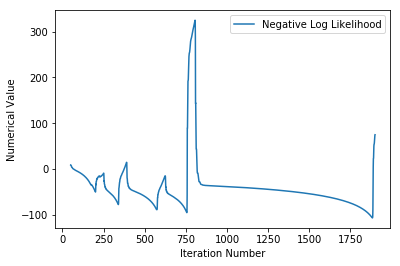

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


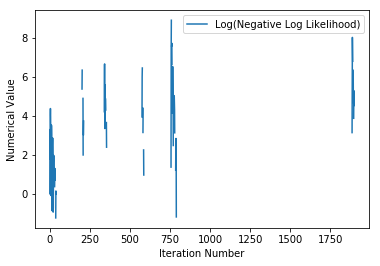

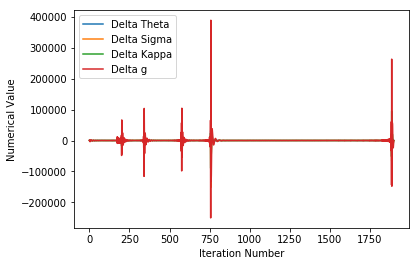

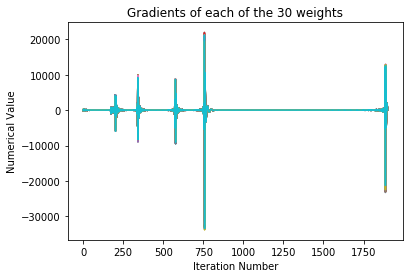

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


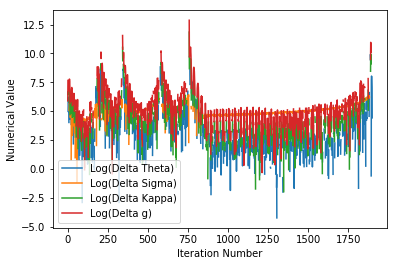

/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log
/Users/gio/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in log


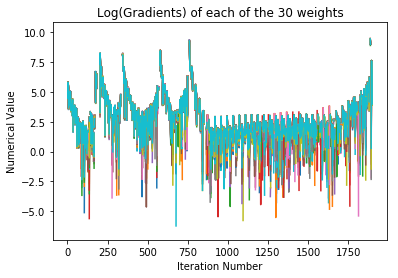

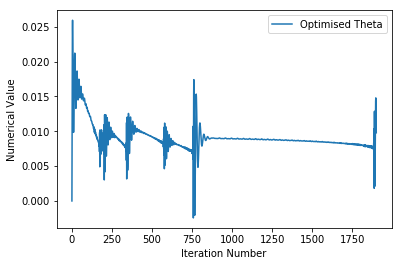

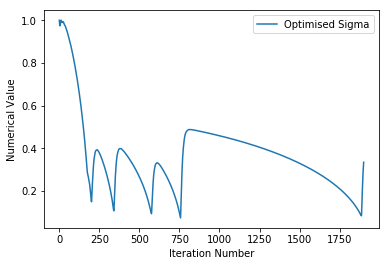

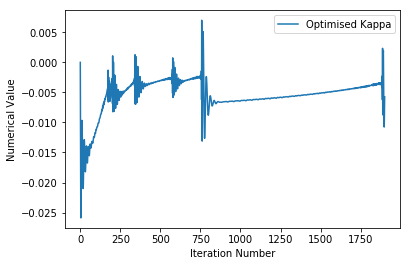

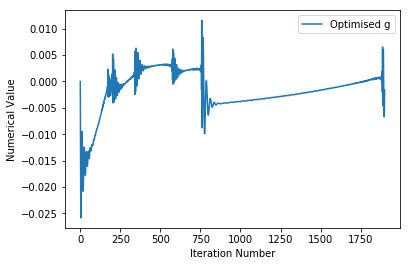

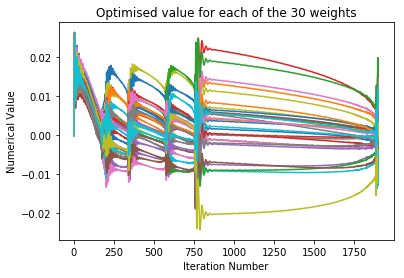

In [0]:
#####Plots for convergence
plt.plot([np.mean(errors[i-50:i]) for i in range(len(errors))], label = "Negative Log Likelihood")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(errors), label = "Log(Negative Log Likelihood)")
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients[:,0], label='Delta Theta')
plt.plot(gradients[:,1], label='Delta Sigma')
plt.plot(gradients[:,2], label='Delta Kappa')
plt.plot(gradients[:,3], label='Delta g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(gradients_weights, label='Delta Weights')
plt.title('Gradients of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients[:,0]), label='Log(Delta Theta)')
plt.plot(np.log(gradients[:,1]), label='Log(Delta Sigma)')
plt.plot(np.log(gradients[:,2]), label='Log(Delta Kappa)')
plt.plot(np.log(gradients[:,3]), label='Log(Delta g)')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(np.log(gradients_weights), label='Log(Delta Weights)')
plt.title('Log(Gradients) of each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_theta, label='Optimised Theta')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_sigma, label='Optimised Sigma')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_kappa, label='Optimised Kappa')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_little_g, label='Optimised g')
plt.legend(loc='best')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

plt.plot(obs_weights_vector, label='Optimised Weights')
plt.title('Optimised value for each of the 30 weights')
plt.ylabel('Numerical Value')
plt.xlabel('Iteration Number')
plt.show()

